In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, recall_score, precision_score, f1_score, roc_auc_score

from warnings import filterwarnings
filterwarnings("ignore")
sns.set_style("darkgrid")  # 'white', 'dark', 'whitegrid', 'darkgrid', 'ticks'

In [10]:
data = load_breast_cancer(as_frame=True)
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [11]:
features = data.data
target = data.target

In [12]:
print(features.shape)
print(target.shape)

(569, 30)
(569,)


In [13]:
features.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [14]:
# Malignant is 0, Benign is 1

print(target.unique())
print('\n', target.value_counts())

[0 1]

 target
1    357
0    212
Name: count, dtype: int64


In [15]:
print(f'Number of columns: {features.shape[1]}')
features.columns

Number of columns: 30


Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [16]:
# rows with null
features.isnull().any(axis=1).sum()

np.int64(0)

In [17]:
# columns with null
features.isnull().any(axis=0).sum()

np.int64(0)

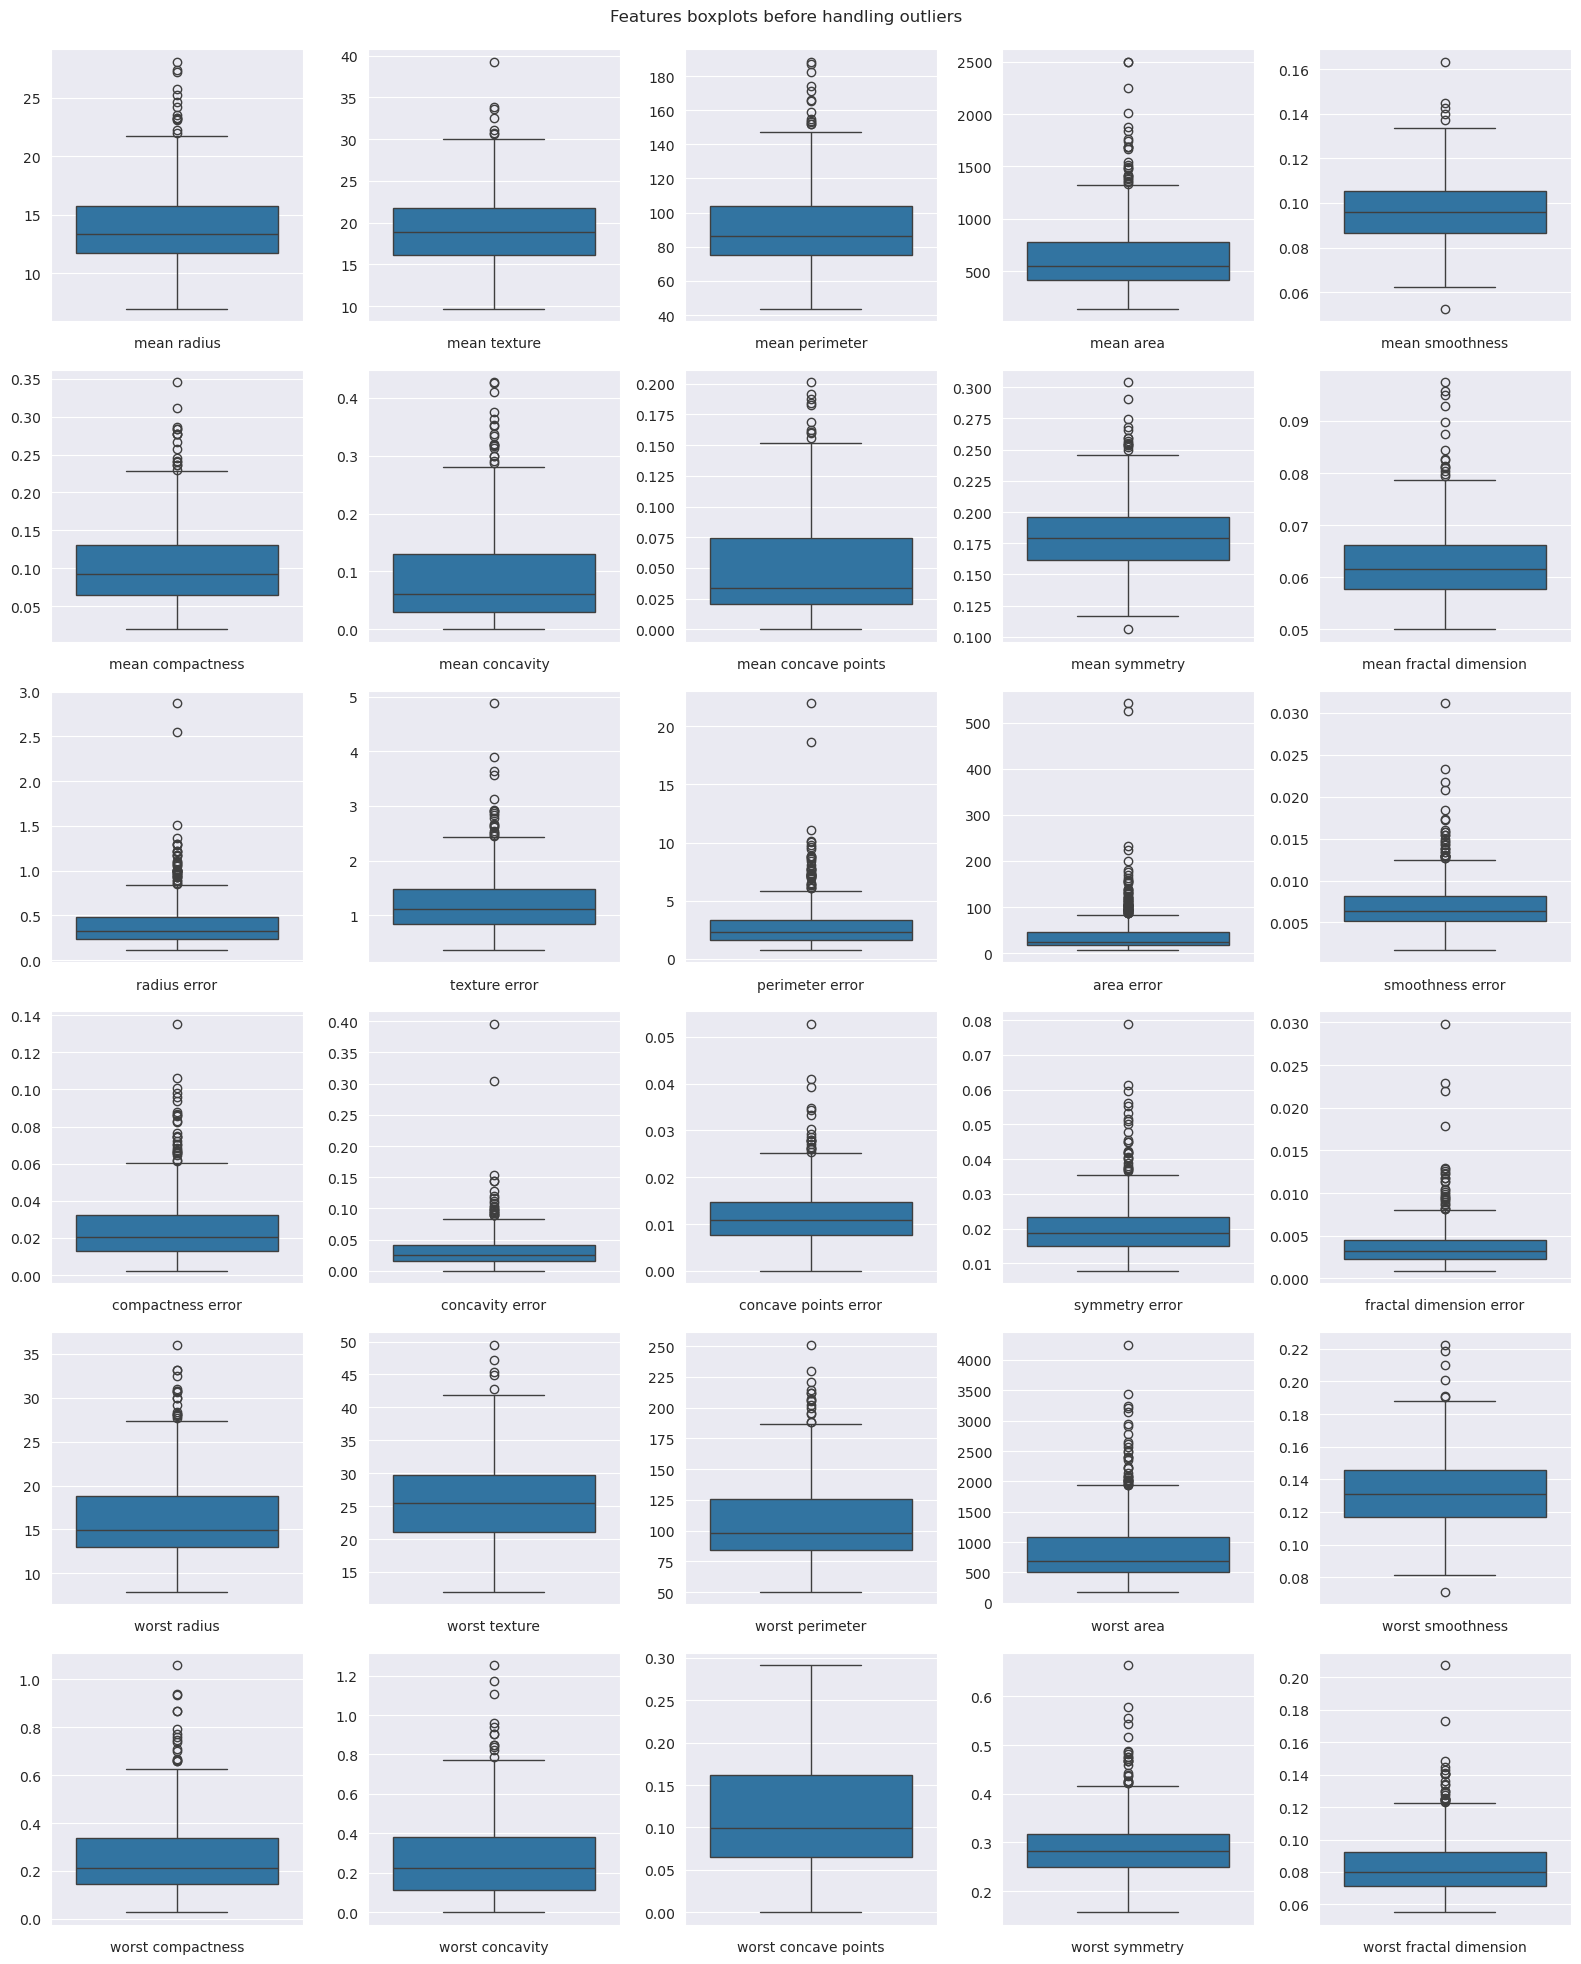

In [18]:
figure, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 20))
figure.suptitle('Features boxplots before handling outliers\n\n')
axes = axes.flatten()

for index, colname in enumerate(features.columns):
    sns.boxplot(features[colname], ax=axes[index])
    axes[index].set_xlabel(colname)
    axes[index].set_ylabel(None)

figure.tight_layout()

In [19]:
def replace_outliers_with_median(df: pd.DataFrame, column_name: str):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    num_outliers = ((df[column_name] < lower_bound) | (df[column_name] > upper_bound)).sum()
    print(f'{column_name}: {num_outliers} outliers')

    median_val = df[column_name].median()

    # Replace
    mask = df[column_name] < lower_bound
    df.loc[mask, column_name] = median_val

    mask = df[column_name] > upper_bound
    df.loc[mask, column_name] = median_val

    return df

In [20]:
# Optional: copy if you want to keep the original untouched
features_without_outliers = features.copy()

for col in features_without_outliers.columns:
    features_without_outliers = replace_outliers_with_median(features_without_outliers, col)

mean radius: 14 outliers
mean texture: 7 outliers
mean perimeter: 13 outliers
mean area: 25 outliers
mean smoothness: 6 outliers
mean compactness: 16 outliers
mean concavity: 18 outliers
mean concave points: 10 outliers
mean symmetry: 15 outliers
mean fractal dimension: 15 outliers
radius error: 38 outliers
texture error: 20 outliers
perimeter error: 38 outliers
area error: 65 outliers
smoothness error: 30 outliers
compactness error: 28 outliers
concavity error: 22 outliers
concave points error: 19 outliers
symmetry error: 27 outliers
fractal dimension error: 28 outliers
worst radius: 17 outliers
worst texture: 5 outliers
worst perimeter: 15 outliers
worst area: 35 outliers
worst smoothness: 7 outliers
worst compactness: 16 outliers
worst concavity: 12 outliers
worst concave points: 0 outliers
worst symmetry: 23 outliers
worst fractal dimension: 24 outliers


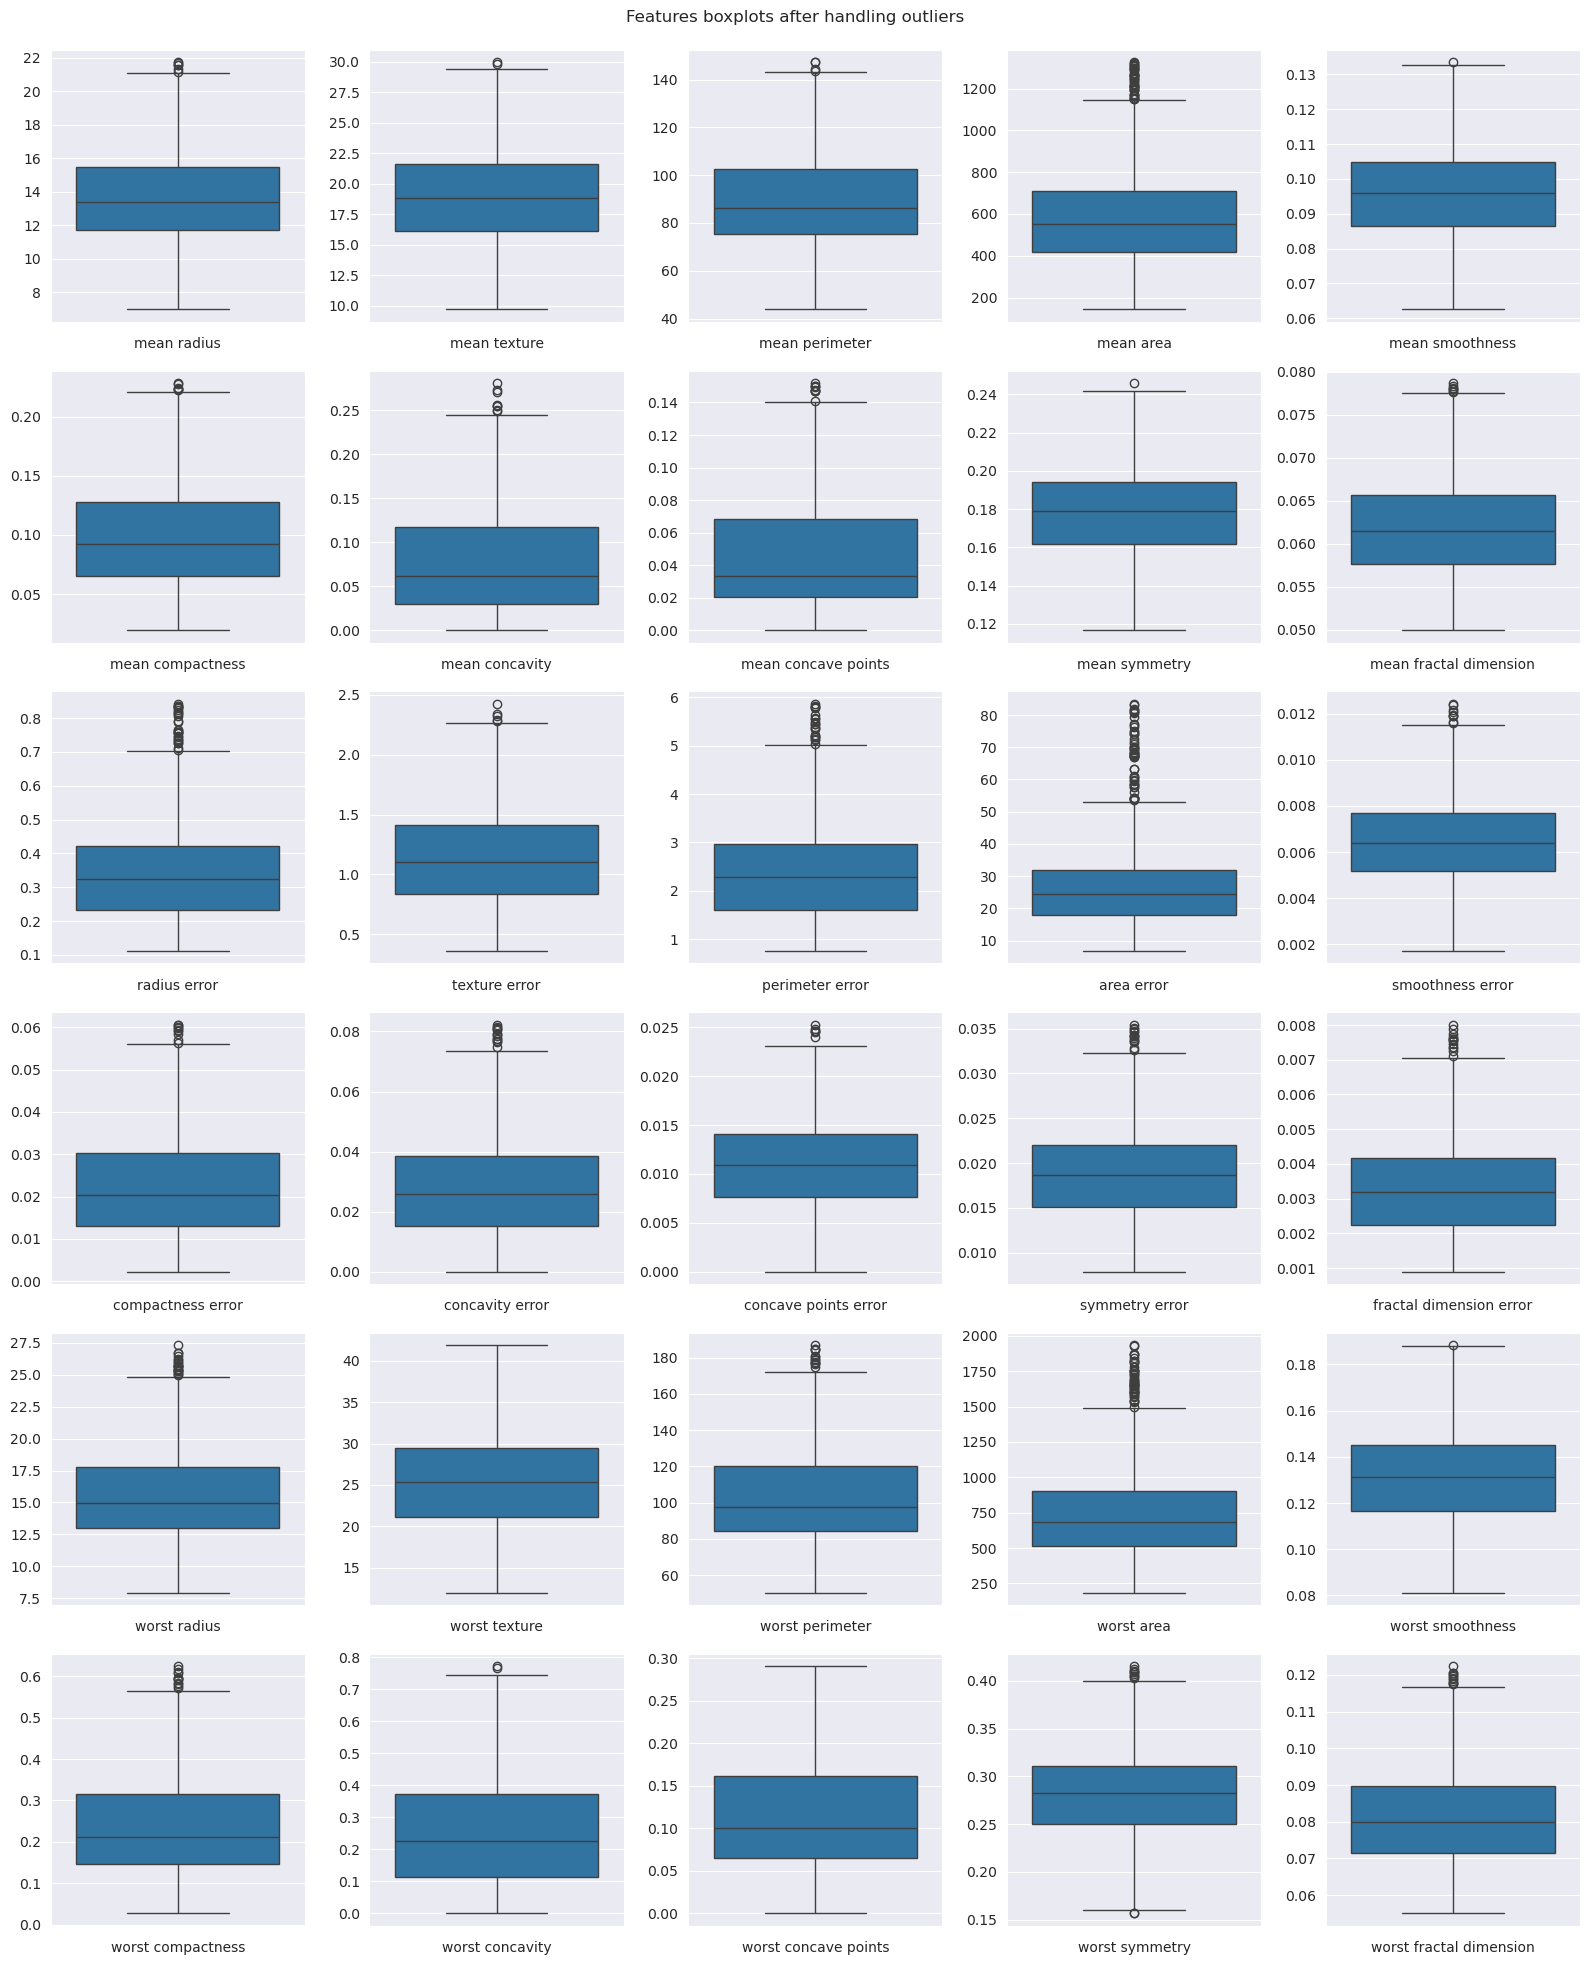

In [21]:
figure, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 20))
figure.suptitle('Features boxplots after handling outliers\n\n')
axes = axes.flatten()

for index, colname in enumerate(features_without_outliers.columns):
    sns.boxplot(features_without_outliers[colname], ax=axes[index])
    axes[index].set_xlabel(colname)
    axes[index].set_ylabel(None)

figure.tight_layout()

---
---

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features_without_outliers, target, test_size=0.3, random_state=100, shuffle=True)

logistic_regression = LogisticRegression(class_weight='balanced').fit(X_train, y_train)


predictions = logistic_regression.predict(X_test)
# Predict class probabilities
class_probability_predictions = logistic_regression.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[60  9]
 [ 6 96]]


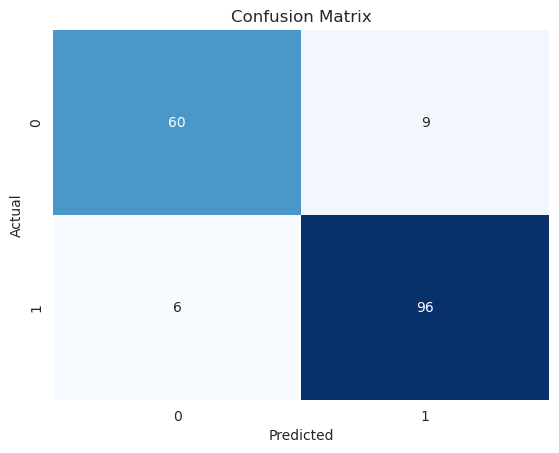

In [23]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
print(f'Confusion Matrix:\n{conf_matrix}')

##  Recall:
* Measures the proportion of correctly predicted positive instances out of all actual positive instances in the dataset.
* It answers the question: "Of all the actual positive samples, how many did the model identify as positive?"

## Precision
* Measures the proportion of correctly predicted positive instances out of all instances predicted as positive.
* It answers the question: "Of all the samples the model identified as positive, how many were actually positive?"

## When to use
* Recall should be prioritized when false negatives are costly.
    * cancer detection: Patient diagnosed as healthy, but actually has cancer.
* Precision should be prioritized when false positives are costly 
    * Bank fraud detection: A legitimate transaction identified as fraud (false positive) and rejecting it, but the customer made a valid and legitimate transaction.

## Trade-off:
* Often, there's a trade-off between precision and recall. Increasing one may decrease the other.
* For example, a spam filter with very high recall (catching almost all spam) might also flag some legitimate emails as spam (lower precision).
* Conversely, a filter with very high precision (only flagging what it's absolutely sure is spam) might miss some spam emails (lower recall). 

## In essence:
* Recall is about how well the model is at finding all the positives that exist. 
* Precision is about how correct the model was, when it predicts something is positive.

In [24]:
rec_score = recall_score(y_test, predictions)
print(f'Recall score: {rec_score:.2f}')
print(f'Model correctly identifies {rec_score * 100:.1f}% of actual breast cancer images')

Recall score: 0.94
Model correctly identifies 94.1% of actual breast cancer images


In [25]:
precision = precision_score(y_test, predictions)
print(f'Precision: {precision:.2f}')
print(f'Of the images classified as breast cancer, {precision * 100:.1f}% were correct.')


Precision: 0.91
Of the images classified as breast cancer, 91.4% were correct.


## F1 score:
* It represents the harmonic mean of precision and recall, providing a balance between these two measures.
* Used when both Precision and Recall are important.
* Particularly useful when dealing with imbalanced datasets.
* F1 score ranges from 0 to 1, with 1 being the best possible score, indicating perfect precision and recall.
* F1 score is useful for comparing the performance of different models, especially when one model has higher precision and another has higher recall. 
* In email spam classification, for example, the F1 score helps optimize the filter to catch spam effectively while minimizing the risk of misclassifying legitimate emails. 

In [26]:
f1 = f1_score(y_test, predictions)
print(f'F1 score: {f1:.2f}')

F1 score: 0.93


In [27]:
acc_score = accuracy_score(y_test, predictions)
log_loss_score = log_loss(y_test, class_probability_predictions)
roc_auc = roc_auc_score(y_test, class_probability_predictions)

print(f'Accuracy score: {acc_score:.2f}')
print(f'Log Loss score: {log_loss_score:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

Accuracy score: 0.91
Log Loss score: 0.35
ROC AUC: 0.94


In [28]:
import joblib

joblib.dump(logistic_regression, 'breast_cancer_logistic_regression.pkl')

['breast_cancer_logistic_regression.pkl']

Text(0.5, 1.0, 'Precision vs Recall')

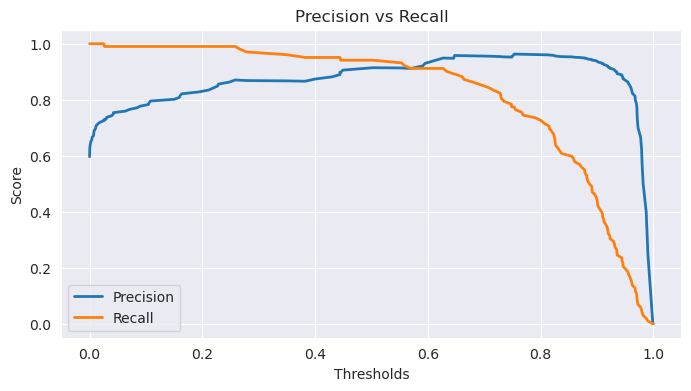

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, class_probability_predictions)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

figure, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.lineplot(x=thresholds, y=precisions[:-1], label="Precision", linewidth=2)
sns.lineplot(x=thresholds, y=recalls[:-1], label="Recall", linewidth=2)
# sns.lineplot(x=thresholds, y=f1_scores[:-1], color='purple', label='F1 Score', linewidth=2)

ax.set_xlabel('Thresholds')
ax.set_ylabel('Score')
ax.set_title('Precision vs Recall')

Confusion Matrix:
[[64  5]
 [ 5 97]]
Model correctly identifies 95.1% of actual breast cancer images
Of the images classified as breast cancer, 95.1% were actually breast cancer.
F1 score: 0.95


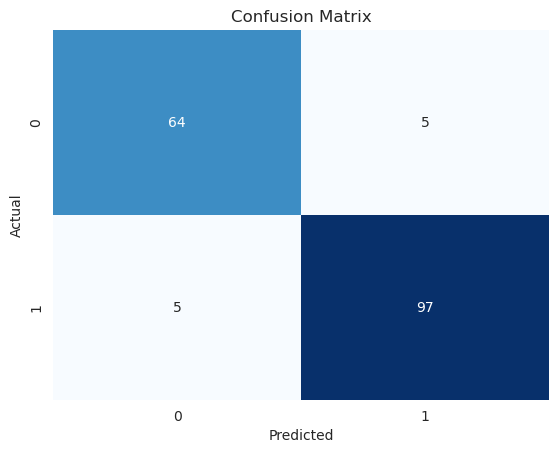

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(features_without_outliers, target, test_size=0.3, random_state=100, shuffle=True)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

logistic_regression = LogisticRegression(class_weight='balanced').fit(X_train_scaled, y_train)


predictions = logistic_regression.predict(X_test_scaled)
# Predict class probabilities
class_probability_predictions = logistic_regression.predict_proba(X_test_scaled)[:, 1]


conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
print(f'Confusion Matrix:\n{conf_matrix}')

rec_score = recall_score(y_test, predictions)
print(f'Model correctly identifies {rec_score * 100:.1f}% of actual breast cancer images')

precision = precision_score(y_test, predictions)
print(f'Of the images classified as breast cancer, {precision * 100:.1f}% were actually breast cancer.')

f1 = f1_score(y_test, predictions)
print(f'F1 score: {f1:.2f}')

---
---
---

Good question.

Even though the first two principal components explain only about 56.56% of the total variance, these components can still capture the most *important* patterns that separate the classes well.

**Why 2 PCA components might be enough despite only \~56% variance explained:**

* **Variance vs. discriminative power:** PCA finds directions of maximum variance, but not necessarily the directions that best separate classes. Sometimes, the first few components capture the main "signal" needed for classification, even if they don't explain all variance.

* **Noise reduction:** The remaining \~44% variance might mostly be noise or irrelevant variation that doesn't help classification, so ignoring it can even improve generalization.

* **Data structure:** The data could be structured so that the main differences between cancer and non-cancer are captured well by these first components.

In short, total variance explained doesn't always directly translate to classification performance. Sometimes fewer components that capture key discriminative information are sufficient.

If you want to improve further, you can try:

* Increasing components (e.g., 3, 4, 5) to see if classification improves
* Use supervised dimensionality reduction methods (e.g., Linear Discriminant Analysis)
* Use the full feature set without PCA and compare

But your current result shows the first two components already capture enough meaningful information for good predictions.


In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(features_without_outliers, target, test_size=0.3, random_state=100, shuffle=True)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

pca = PCA(n_components=2)  # 2 principla components

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

variance_explained = pca.explained_variance_ratio_

print(f'Number of features before PCA: {features.shape[1]}')
print(f'Number of components selected: {pca.n_components_}')
print(f'Explained variance ratio: {variance_explained}')
print(f"Cumulative variance retained: {np.sum(variance_explained) * 100:.2f}%")

lr = LogisticRegression(class_weight='balanced').fit(X_train_pca, y_train)
predictions = lr.predict(X_test_pca)

rec_score = recall_score(y_test, predictions)
print(f'\n\nModel correctly identifies {rec_score * 100:.1f}% of actual breast cancer images')

precision = precision_score(y_test, predictions)
print(f'Of the images classified as breast cancer, {precision * 100:.1f}% were actually breast cancer.')

f1 = f1_score(y_test, predictions)
print(f'F1 score: {f1:.2f}')

Number of features before PCA: 30
Number of components selected: 2
Explained variance ratio: [0.40424955 0.16136022]
Cumulative variance retained: 56.56%


Model correctly identifies 95.1% of actual breast cancer images
Of the images classified as breast cancer, 96.0% were actually breast cancer.
F1 score: 0.96


Text(0.5, 1.0, 'First component vs Second CompAonent')

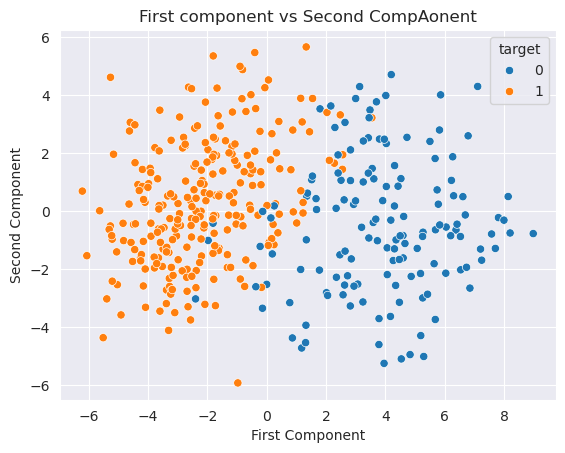

In [32]:
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('First component vs Second CompAonent')